In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# -----------------------------
# CONFIG
# -----------------------------
N = 10000
random.seed(42)
np.random.seed(42)

neighborhoods = [
    "Kombinat", "Laprakë", "Ali Demi", "Don Bosko",
    "Blloku", "Astir", "Yzberisht", "Kinostudio",
    "Fresku", "Paskuqan"
]

weather_options = ["Clear", "Rain", "Heat"]
animal_types = ["Dog", "Cat"]
behaviors = ["Calm", "Aggressive", "Weak", "Fearful"]
mobility_states = ["Normal", "Limping", "Immobile"]
traffic_levels = ["Low", "Medium", "High"]
channels = ["Call", "App", "Walk-in"]

# -----------------------------
# Helper Functions
# -----------------------------
def random_date():
    start = datetime(2024, 1, 1)
    end = datetime(2025, 1, 1)
    return start + timedelta(days=random.randint(0, 364),
                             hours=random.randint(0, 23))

def calculate_severity(row):
    score = 10
    if row["visible_injury"] == "Yes":
        score += 30
    if row["mobility"] == "Immobile":
        score += 25
    if row["traffic_risk"] == "High":
        score += 20
    if row["behavior"] == "Aggressive":
        score += 10
    return min(score, 100)

def assign_priority(severity):
    if severity >= 70:
        return "P1"
    elif severity >= 40:
        return "P2"
    else:
        return "P3"

def resolution_time(priority):
    if priority == "P1":
        return round(np.random.uniform(1, 6), 1)
    elif priority == "P2":
        return round(np.random.uniform(6, 24), 1)
    else:
        return round(np.random.uniform(24, 72), 1)

# -----------------------------
# DATA GENERATION
# -----------------------------
rows = []

for i in range(N):
    row = {
        "incident_id": f"INC-{100000+i}",
        "reported_at": random_date(),
        "city": "Tirana",
        "neighborhood": random.choice(neighborhoods),
        "animal_type": random.choice(animal_types),
        "animal_count": random.randint(1, 3),
        "age_group": random.choice(["Puppy/Kitten", "Adult", "Unknown"]),
        "visible_injury": random.choice(["Yes", "No"]),
        "behavior": random.choice(behaviors),
        "mobility": random.choice(mobility_states),
        "traffic_risk": random.choice(traffic_levels),
        "weather": random.choice(weather_options),
        "report_channel": random.choice(channels),
        "description": "Reported stray animal requiring assessment"
    }

    # Targets (generated AFTER inputs)
    severity = calculate_severity(row)
    priority = assign_priority(severity)
    resolution = resolution_time(priority)

    row["severity_score"] = severity
    row["priority"] = priority
    row["resolution_time_hours"] = resolution
    row["outcome"] = random.choice(["Treated", "Shelter", "Monitor", "Lost"])

    rows.append(row)

df = pd.DataFrame(rows)

# Save
df.to_csv("tirana_stray_animals_incidents.csv", index=False)

print("✅ Dataset created successfully!")


In [ ]:

# ============================================
# Model A: Priority (classification) + Severity (regression)
# No data leakage, ML-ready pipeline
# ============================================

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.linear_model import LogisticRegression, Ridge
import joblib

# -----------------------------
# 1) Load data
# -----------------------------
df = pd.read_csv("tirana_stray_animals_incidents.csv")

# Parse datetime safely
df["reported_at"] = pd.to_datetime(df["reported_at"], errors="coerce")

# -----------------------------
# 2) Feature Engineering (safe: only from report-time info)
# -----------------------------
# Create time features (safe, known at report time)
df["report_hour"] = df["reported_at"].dt.hour.fillna(0).astype(int)
df["report_dayofweek"] = df["reported_at"].dt.dayofweek.fillna(0).astype(int)
df["report_month"] = df["reported_at"].dt.month.fillna(1).astype(int)

# Ensure description is non-null
df["description"] = df["description"].fillna("")

# -----------------------------
# 3) Define NO-LEAK feature set
# -----------------------------
# Targets:
y_priority = df["priority"]
y_severity = df["severity_score"]

# ❌ Do NOT use these as features (leakage / post-outcome):
# - severity_score (target)
# - priority (target)
# - resolution_time_hours (post-resolution)
# - outcome (post-resolution)
# - resolution_status (often post-resolution / workflow dependent)
#
# ✅ Only report-time features:
feature_cols = [
    "neighborhood", "animal_type", "animal_count", "age_group",
    "visible_injury", "behavior", "mobility", "traffic_risk",
    "weather", "report_channel", "description",
    "report_hour", "report_dayofweek", "report_month"
]
X = df[feature_cols].copy()

# -----------------------------
# 4) Split (stratify for priority)
# -----------------------------
X_train, X_test, y_priority_train, y_priority_test = train_test_split(
    X, y_priority, test_size=0.2, random_state=42, stratify=y_priority
)

# For severity model, use the SAME split indices to keep it consistent
# (We align by index)
y_severity_train = y_severity.loc[X_train.index]
y_severity_test = y_severity.loc[X_test.index]

# -----------------------------
# 5) Preprocessing
# -----------------------------
text_col = "description"
numeric_cols = ["animal_count", "report_hour", "report_dayofweek", "report_month"]
categorical_cols = [
    "neighborhood", "animal_type", "age_group", "visible_injury",
    "behavior", "mobility", "traffic_risk", "weather", "report_channel"
]

preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=8000, ngram_range=(1, 2), stop_words="english"), text_col),
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop"
)

# -----------------------------
# 6) Model 1: Priority Classification
# -----------------------------
priority_model = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

priority_model.fit(X_train, y_priority_train)
pred_priority = priority_model.predict(X_test)

print("\n==============================")
print("PRIORITY MODEL (Classification)")
print("==============================")
print("Accuracy:", round(accuracy_score(y_priority_test, pred_priority), 4))
print("\nClassification Report:\n", classification_report(y_priority_test, pred_priority))
print("Confusion Matrix:\n", confusion_matrix(y_priority_test, pred_priority))

# -----------------------------
# 7) Model 2: Severity Regression
# -----------------------------
# Note: Severity is a numeric 0-100. Ridge is a solid baseline.
severity_model = Pipeline(steps=[
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

severity_model.fit(X_train, y_severity_train)
pred_severity = severity_model.predict(X_test)

# Clip predictions to valid range
pred_severity = np.clip(pred_severity, 0, 100)

mae = mean_absolute_error(y_severity_test, pred_severity)
rmse = mean_squared_error(y_severity_test, pred_severity, squared=False)
r2 = r2_score(y_severity_test, pred_severity)

print("\n==============================")
print("SEVERITY MODEL (Regression)")
print("==============================")
print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("R2:", round(r2, 3))

# -----------------------------
# 8) Save artifacts (for real-work demo)
# -----------------------------
joblib.dump(priority_model, "priority_model_tirana.joblib")
joblib.dump(severity_model, "severity_model_tirana.joblib")

print("\n✅ Saved models:")
print("- priority_model_tirana.joblib")
print("- severity_model_tirana.joblib")


In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# -----------------------------
# CONFIG
# -----------------------------
N = 12000  # incidents
START_DATE = datetime(2025, 1, 1)
END_DATE   = datetime(2026, 1, 1)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Tirana neighborhoods (reasonable sample)
NEIGHBORHOODS = [
    "Kombinat", "Laprakë", "Ali Demi", "Don Bosko", "Blloku",
    "Astir", "Yzberisht", "Kinostudio", "Fresku", "Paskuqan",
    "Selitë", "Rruga e Kavajës", "Myslym Shyri", "Xhamllik", "21 Dhjetori"
]

ANIMAL_TYPES = ["Dog", "Cat"]
AGE_GROUPS = ["Puppy/Kitten", "Adult", "Senior", "Unknown"]
BEHAVIORS = ["Calm", "Fearful", "Aggressive", "Weak", "Unknown"]
MOBILITY = ["Normal", "Limping", "Immobile", "Unknown"]
TRAFFIC = ["Low", "Medium", "High"]
WEATHER = ["Clear", "Rain", "Heatwave", "Cold"]
CHANNELS = ["Call", "WhatsApp", "App", "Walk-in", "Email"]

# Neighborhood baseline risk (some areas higher incident complexity)
NEIGHBORHOOD_RISK = {
    "Kombinat": 1.10, "Laprakë": 1.05, "Ali Demi": 1.00, "Don Bosko": 0.95,
    "Blloku": 0.85, "Astir": 1.05, "Yzberisht": 1.10, "Kinostudio": 0.95,
    "Fresku": 1.00, "Paskuqan": 1.10, "Selitë": 0.95, "Rruga e Kavajës": 0.90,
    "Myslym Shyri": 0.85, "Xhamllik": 1.00, "21 Dhjetori": 0.95
}

# Description templates (these are INPUTS; do not encode label directly)
DESC_TEMPLATES = [
    "Stray {animal} seen near {place}. Reporter concerned about safety.",
    "{animal} appears {state}. Spotted close to traffic.",
    "Possible {issue} reported for a stray {animal}. Needs assessment.",
    "Multiple stray {animal_plural} near {place}.",
    "{animal} found wandering. Reporter unsure if injured.",
    "Stray {animal} in residential area; community requesting help.",
]

PLACES = ["bus station", "market", "school", "park", "main road", "construction site", "apartment block"]
STATES = ["thin", "tired", "scared", "agitated", "confused", "weak"]
ISSUES = ["injury", "illness", "limp", "skin issue", "dehydration", "unknown problem"]

OUTCOMES = ["Treated & Released", "Shelter Intake", "Monitor", "Unable to Locate", "Referred to Partner Vet"]

def random_datetime(start, end):
    delta = end - start
    seconds = random.randint(0, int(delta.total_seconds()) - 1)
    return start + timedelta(seconds=seconds)

def season_from_month(m):
    if m in [12, 1, 2]:
        return "Winter"
    if m in [3, 4, 5]:
        return "Spring"
    if m in [6, 7, 8]:
        return "Summer"
    return "Autumn"

def sample_weather(season):
    # weather depends on season
    if season == "Summer":
        return np.random.choice(["Clear", "Heatwave", "Clear", "Clear", "Rain"], p=[0.55, 0.15, 0.15, 0.10, 0.05])
    if season == "Winter":
        return np.random.choice(["Cold", "Rain", "Clear"], p=[0.50, 0.30, 0.20])
    if season == "Autumn":
        return np.random.choice(["Rain", "Clear", "Cold"], p=[0.45, 0.45, 0.10])
    return np.random.choice(["Clear", "Rain", "Clear"], p=[0.60, 0.25, 0.15])  # Spring

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def generate_description(animal):
    tmpl = random.choice(DESC_TEMPLATES)
    place = random.choice(PLACES)
    state = random.choice(STATES)
    issue = random.choice(ISSUES)
    animal_plural = "dogs" if animal == "Dog" else "cats"
    return tmpl.format(animal=animal.lower(), animal_plural=animal_plural, place=place, state=state, issue=issue)

def noisy_yes_no(true_prob):
    return "Yes" if random.random() < true_prob else "No"

# Hidden operational factor (NOT in features) to make realism (no perfect predictability)
def hidden_capacity_factor(dt):
    # weekends / nights have lower capacity; random shocks too
    base = 0.0
    if dt.weekday() >= 5:  # Sat/Sun
        base += 0.4
    if dt.hour < 8 or dt.hour > 20:
        base += 0.4
    # occasional busy day
    if random.random() < 0.05:
        base += 0.8
    return base

rows = []
actions_rows = []

for i in range(N):
    reported_at = random_datetime(START_DATE, END_DATE)
    month = reported_at.month
    season = season_from_month(month)
    weather = sample_weather(season)

    neighborhood = random.choice(NEIGHBORHOODS)
    risk_mult = NEIGHBORHOOD_RISK.get(neighborhood, 1.0)

    animal_type = random.choice(ANIMAL_TYPES)
    age_group = np.random.choice(AGE_GROUPS, p=[0.20, 0.55, 0.10, 0.15])
    report_channel = np.random.choice(CHANNELS, p=[0.35, 0.25, 0.20, 0.15, 0.05])

    # Traffic risk depends a bit on neighborhood + hour (rush hour)
    rush = 1 if reported_at.hour in [7, 8, 9, 16, 17, 18] else 0
    traffic_risk = np.random.choice(
        TRAFFIC,
        p=[0.35 - 0.10*rush, 0.45, 0.20 + 0.10*rush]
    )
    traffic_risk = str(traffic_risk)

    # Behavior and mobility with uncertainty / unknowns
    behavior = np.random.choice(BEHAVIORS, p=[0.45, 0.25, 0.10, 0.10, 0.10])
    mobility = np.random.choice(MOBILITY, p=[0.60, 0.18, 0.07, 0.15])

    # Injury is imperfectly reported: depends on true condition but noisy
    # We'll define a latent "health severity driver" first:
    latent = 0.0
    latent += 0.6 if mobility == "Immobile" else 0.2 if mobility == "Limping" else 0.0
    latent += 0.5 if behavior == "Weak" else 0.2 if behavior == "Aggressive" else 0.0
    latent += 0.35 if traffic_risk == "High" else 0.15 if traffic_risk == "Medium" else 0.0
    latent += 0.25 if weather in ["Heatwave", "Cold"] else 0.0
    latent += 0.10 if age_group in ["Puppy/Kitten", "Senior"] else 0.0
    latent *= risk_mult

    # Reporter "visible injury" signal is noisy, not perfect
    # true probability rises with latent severity, but not deterministic
    visible_injury = noisy_yes_no(sigmoid(-0.2 + 1.2*latent) * 0.75)  # capped-ish realism

    animal_count = int(np.random.choice([1, 2, 3, 4], p=[0.72, 0.18, 0.07, 0.03]))

    description = generate_description(animal_type)

    # ----------------------------------------------------
    # TARGETS (generated AFTER inputs; not used as inputs)
    # ----------------------------------------------------
    # Severity score: continuous, noisy, includes hidden capacity & random shocks
    cap = hidden_capacity_factor(reported_at)  # hidden (not in dataset features)
    noise = np.random.normal(0, 10)

    severity_score = (
        18
        + (22 if visible_injury == "Yes" else 0)
        + (18 if mobility == "Immobile" else 9 if mobility == "Limping" else 0)
        + (12 if traffic_risk == "High" else 6 if traffic_risk == "Medium" else 0)
        + (10 if behavior == "Weak" else 5 if behavior == "Aggressive" else 0)
        + (8 if weather in ["Heatwave", "Cold"] else 0)
        + (6 if age_group in ["Puppy/Kitten", "Senior"] else 0)
        + noise
    )

    severity_score = int(np.clip(severity_score, 0, 100))

    # Priority: probabilistic (prevents perfect accuracy)
    # Convert severity into probabilities (soft boundaries)
    p1 = sigmoid((severity_score - 72) / 8) * 0.70
    p2 = sigmoid((severity_score - 45) / 10) * 0.75 * (1 - p1)
    p3 = max(0.0, 1 - (p1 + p2))

    # normalize
    total = p1 + p2 + p3
    p1, p2, p3 = p1/total, p2/total, p3/total

    priority = np.random.choice(["P1", "P2", "P3"], p=[p1, p2, p3])

    # Resolution time: depends on severity + capacity (hidden) + randomness
    base_hours = (
        2.5 if priority == "P1" else
        10.0 if priority == "P2" else
        36.0
    )

    # severity impacts time but not perfectly
    res_noise = np.random.lognormal(mean=0.0, sigma=0.35)  # multiplicative noise
    resolution_time_hours = base_hours * (1 + (severity_score / 140)) * (1 + 0.35*cap) * res_noise
    resolution_time_hours = float(np.clip(resolution_time_hours, 0.5, 240.0))

    # Outcome: correlated but noisy
    # Higher severity more likely to "Shelter Intake" or "Partner Vet"
    outcome_probs = {
        "Treated & Released": max(0.05, 0.55 - severity_score/140),
        "Shelter Intake":     min(0.55, 0.20 + severity_score/170),
        "Monitor":            max(0.05, 0.25 - severity_score/200),
        "Unable to Locate":   0.10 + (0.05 if animal_type == "Cat" else 0.00),
        "Referred to Partner Vet": min(0.35, 0.05 + severity_score/200)
    }
    # normalize
    keys = list(outcome_probs.keys())
    vals = np.array([outcome_probs[k] for k in keys], dtype=float)
    vals = np.clip(vals, 0.01, None)
    vals = vals / vals.sum()
    outcome = np.random.choice(keys, p=vals)

    # Status: if within last 14 days, some still open
    days_ago = (END_DATE - reported_at).days
    if days_ago < 14 and random.random() < 0.20:
        resolution_status = "Open"
    else:
        resolution_status = "Closed"

    incident_id = f"INC-{100000 + i}"

    rows.append({
        "incident_id": incident_id,
        "reported_at": reported_at.strftime("%Y-%m-%d %H:%M:%S"),
        "city": "Tirana",
        "neighborhood": neighborhood,
        "animal_type": animal_type,
        "animal_count": animal_count,
        "age_group": age_group,
        "visible_injury": visible_injury,
        "behavior": behavior,
        "mobility": mobility,
        "traffic_risk": traffic_risk,
        "weather": weather,
        "report_channel": report_channel,
        "description": description,

        # Targets:
        "severity_score": severity_score,
        "priority": priority,
        "resolution_time_hours": round(resolution_time_hours, 2),
        "outcome": outcome,
        "resolution_status": resolution_status,
    })

    # Actions table: realistic tracking (not needed for ML, but good for “work feel”)
    # Create 1–3 actions if closed, else 1 action
    num_actions = 1 if resolution_status == "Open" else np.random.choice([1, 2, 3], p=[0.35, 0.45, 0.20])
    action_time = reported_at + timedelta(minutes=int(np.random.uniform(10, 180)))

    for a in range(int(num_actions)):
        action_type = np.random.choice(
            ["Triage", "Dispatched", "On-site Check", "Pickup", "Vet Transfer", "Follow-up", "Closed"],
            p=[0.20, 0.18, 0.18, 0.14, 0.10, 0.12, 0.08]
        )
        team = np.random.choice(
            ["Municipal Team", "NGO Partner", "Volunteer Network", "Partner Vet"],
            p=[0.35, 0.25, 0.25, 0.15]
        )
        actions_rows.append({
            "action_id": f"ACT-{incident_id}-{a+1}",
            "incident_id": incident_id,
            "action_time": action_time.strftime("%Y-%m-%d %H:%M:%S"),
            "action_type": action_type,
            "team": team,
            "notes": ""
        })
        action_time += timedelta(minutes=int(np.random.uniform(30, 360)))

# Locations table (lookup)
loc_rows = []
for nb in NEIGHBORHOODS:
    density = np.random.choice(["Low", "Medium", "High"], p=[0.20, 0.55, 0.25])
    dist_km = float(np.round(np.random.uniform(1.0, 9.0), 1))
    loc_rows.append({
        "city": "Tirana",
        "neighborhood": nb,
        "population_density": density,
        "distance_to_shelter_km": dist_km
    })

incidents_df = pd.DataFrame(rows)
actions_df = pd.DataFrame(actions_rows)
locations_df = pd.DataFrame(loc_rows)

# Basic cleanliness: enforce types / missing handling
incidents_df["description"] = incidents_df["description"].fillna("")
incidents_df["behavior"] = incidents_df["behavior"].fillna("Unknown")
incidents_df["mobility"] = incidents_df["mobility"].fillna("Unknown")

incidents_df.to_csv("incidents_tirana.csv", index=False)
actions_df.to_csv("actions_tirana.csv", index=False)
locations_df.to_csv("locations_tirana.csv", index=False)

print("✅ Created:")
print("- incidents_tirana.csv")
print("- actions_tirana.csv")
print("- locations_tirana.csv")
print("\nIncidents shape:", incidents_df.shape)
print("Priority distribution:\n", incidents_df["priority"].value_counts(normalize=True).round(3))


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)
import joblib

# -----------------------------
# Load
# -----------------------------
df = pd.read_csv("incidents_tirana.csv")
df["reported_at"] = pd.to_datetime(df["reported_at"], errors="coerce")

# Sort by time for a realistic split
df = df.sort_values("reported_at").reset_index(drop=True)

# -----------------------------
# Feature Engineering (safe)
# -----------------------------
df["report_hour"] = df["reported_at"].dt.hour.fillna(0).astype(int)
df["report_dayofweek"] = df["reported_at"].dt.dayofweek.fillna(0).astype(int)
df["report_month"] = df["reported_at"].dt.month.fillna(1).astype(int)
df["description"] = df["description"].fillna("")

# Targets
y_priority = df["priority"]
y_severity = df["severity_score"]

# ✅ No-leak features: ONLY report-time fields
feature_cols = [
    "neighborhood", "animal_type", "animal_count", "age_group",
    "visible_injury", "behavior", "mobility", "traffic_risk",
    "weather", "report_channel", "description",
    "report_hour", "report_dayofweek", "report_month"
]
X = df[feature_cols].copy()

# -----------------------------
# Time-based split (no peeking into the future)
# -----------------------------
split_idx = int(len(df) * 0.80)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_priority_train, y_priority_test = y_priority.iloc[:split_idx], y_priority.iloc[split_idx:]
y_severity_train, y_severity_test = y_severity.iloc[:split_idx], y_severity.iloc[split_idx:]

# -----------------------------
# Preprocess
# -----------------------------
text_col = "description"
numeric_cols = ["animal_count", "report_hour", "report_dayofweek", "report_month"]
categorical_cols = [
    "neighborhood", "animal_type", "age_group", "visible_injury",
    "behavior", "mobility", "traffic_risk", "weather", "report_channel"
]

preprocess = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=6000, ngram_range=(1, 2), stop_words="english"), text_col),
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

# -----------------------------
# Priority model
# -----------------------------
priority_model = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

priority_model.fit(X_train, y_priority_train)
pred_priority = priority_model.predict(X_test)

print("\n==============================")
print("PRIORITY MODEL (Classification)")
print("==============================")
print("Accuracy:", round(accuracy_score(y_priority_test, pred_priority), 4))
print("\nClassification Report:\n", classification_report(y_priority_test, pred_priority))
print("Confusion Matrix:\n", confusion_matrix(y_priority_test, pred_priority))

# -----------------------------
# Severity model
# -----------------------------
severity_model = Pipeline([
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

severity_model.fit(X_train, y_severity_train)
pred_severity = severity_model.predict(X_test)
pred_severity = np.clip(pred_severity, 0, 100)

mae = mean_absolute_error(y_severity_test, pred_severity)
rmse = np.sqrt(mean_squared_error(y_severity_test, pred_severity))  # compatible fix
r2 = r2_score(y_severity_test, pred_severity)

print("\n==============================")
print("SEVERITY MODEL (Regression)")
print("==============================")
print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("R2:", round(r2, 3))

# -----------------------------
# Save
# -----------------------------
joblib.dump(priority_model, "priority_model_tirana.joblib")
joblib.dump(severity_model, "severity_model_tirana.joblib")

print("\n✅ Saved models:")
print("- priority_model_tirana.joblib")
print("- severity_model_tirana.joblib")


In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# -----------------------------
# CONFIG
# -----------------------------
N = 15000
START_DATE = datetime(2025, 1, 1)
END_DATE   = datetime(2026, 1, 1)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

NEIGHBORHOODS = [
    "Kombinat", "Laprakë", "Ali Demi", "Don Bosko", "Blloku",
    "Astir", "Yzberisht", "Kinostudio", "Fresku", "Paskuqan",
    "Selitë", "Rruga e Kavajës", "Myslym Shyri", "Xhamllik", "21 Dhjetori"
]

ANIMAL_TYPES = ["Dog", "Cat"]
AGE_GROUPS = ["Puppy/Kitten", "Adult", "Senior", "Unknown"]
BEHAVIORS = ["Calm", "Fearful", "Aggressive", "Weak", "Unknown"]
MOBILITY = ["Normal", "Limping", "Immobile", "Unknown"]
CHANNELS = ["Call", "WhatsApp", "App", "Walk-in", "Email"]

def random_datetime(start, end):
    delta = end - start
    seconds = random.randint(0, int(delta.total_seconds()) - 1)
    return start + timedelta(seconds=seconds)

def season_from_month(m):
    if m in [12, 1, 2]: return "Winter"
    if m in [3, 4, 5]: return "Spring"
    if m in [6, 7, 8]: return "Summer"
    return "Autumn"

def sample_weather(season):
    if season == "Summer":
        return np.random.choice(["Clear", "Heatwave", "Rain"], p=[0.70, 0.20, 0.10])
    if season == "Winter":
        return np.random.choice(["Cold", "Rain", "Clear"], p=[0.55, 0.30, 0.15])
    if season == "Autumn":
        return np.random.choice(["Rain", "Clear", "Cold"], p=[0.45, 0.45, 0.10])
    return np.random.choice(["Clear", "Rain", "Clear"], p=[0.60, 0.25, 0.15])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Hidden factor (NOT in features) to prevent perfect prediction
def hidden_ops_pressure(dt):
    pressure = 0.0
    if dt.weekday() >= 5: pressure += 0.35
    if dt.hour < 8 or dt.hour > 20: pressure += 0.35
    if random.random() < 0.06: pressure += 0.7
    return pressure

rows = []

for i in range(N):
    reported_at = random_datetime(START_DATE, END_DATE)
    season = season_from_month(reported_at.month)
    weather = sample_weather(season)

    neighborhood = random.choice(NEIGHBORHOODS)
    animal_type = random.choice(ANIMAL_TYPES)

    age_group = np.random.choice(AGE_GROUPS, p=[0.22, 0.54, 0.10, 0.14])
    behavior = np.random.choice(BEHAVIORS, p=[0.42, 0.26, 0.10, 0.10, 0.12])
    mobility = np.random.choice(MOBILITY, p=[0.60, 0.18, 0.07, 0.15])
    report_channel = np.random.choice(CHANNELS, p=[0.35, 0.25, 0.20, 0.15, 0.05])

    # Report-time structured symptom flags (THIS is the key improvement)
    # They are not perfect (some noise), but strongly informative.
    very_thin = np.random.binomial(1, 0.18)
    bleeding = np.random.binomial(1, 0.06)
    open_wound = np.random.binomial(1, 0.05)
    pregnant_or_nursing = np.random.binomial(1, 0.07 if animal_type == "Cat" else 0.04)
    has_collar = np.random.binomial(1, 0.10 if neighborhood in ["Blloku", "Myslym Shyri"] else 0.06)

    # Environment flags (known at report time)
    near_school = np.random.binomial(1, 0.14)
    near_traffic = np.random.binomial(1, 0.35)

    # Reporter confidence: 1 (low) to 5 (high)
    reporter_confidence = int(np.random.choice([1,2,3,4,5], p=[0.10,0.20,0.35,0.25,0.10]))

    # Derive a "traffic_risk" category from near_traffic + rush hours (still report-time)
    rush = 1 if reported_at.hour in [7, 8, 9, 16, 17, 18] else 0
    traffic_score = (0.7*near_traffic) + (0.3*rush) + np.random.normal(0, 0.15)
    traffic_risk = "High" if traffic_score > 0.75 else "Medium" if traffic_score > 0.35 else "Low"

    # Visible injury (noisy, but based on flags + mobility)
    injury_signal = 0.0
    injury_signal += 1.0 if bleeding else 0.0
    injury_signal += 0.9 if open_wound else 0.0
    injury_signal += 0.5 if mobility == "Immobile" else 0.2 if mobility == "Limping" else 0.0
    visible_injury = "Yes" if random.random() < sigmoid(-0.3 + injury_signal) else "No"

    animal_count = int(np.random.choice([1,2,3,4], p=[0.74,0.17,0.06,0.03]))

    # -----------------------------
    # TARGETS (generated AFTER)
    # -----------------------------
    ops_pressure = hidden_ops_pressure(reported_at)

    # Severity: more learnable (structured flags), but still noisy
    severity = 15
    severity += 25 if bleeding else 0
    severity += 20 if open_wound else 0
    severity += 12 if very_thin else 0
    severity += 10 if mobility == "Immobile" else 6 if mobility == "Limping" else 0
    severity += 8 if weather in ["Heatwave", "Cold"] else 0
    severity += 6 if near_traffic else 0
    severity += 6 if near_school else 0
    severity += 5 if behavior == "Weak" else 3 if behavior == "Aggressive" else 0
    severity += 6 if age_group in ["Puppy/Kitten", "Senior"] else 0
    severity += np.random.normal(0, 6)  # noise (keeps it real)
    severity = int(np.clip(severity, 0, 100))

    # Priority: NOT deterministic, but less random than before (better accuracy)
    # Use severity + a bit of confidence + environment
    p1 = sigmoid((severity - 70)/7) * 0.75
    p2 = sigmoid((severity - 42)/9) * 0.80 * (1 - p1)
    # confidence nudges (high confidence = more likely to assign higher priority)
    conf_nudge = (reporter_confidence - 3) * 0.03
    p1 = np.clip(p1 + conf_nudge, 0, 0.90)
    p2 = np.clip(p2, 0, 0.95)
    p3 = max(0.0, 1 - (p1 + p2))
    total = p1+p2+p3
    p1,p2,p3 = p1/total, p2/total, p3/total

    priority = np.random.choice(["P1","P2","P3"], p=[p1,p2,p3])

    # Resolution time (target), depends on ops_pressure too
    base = 3 if priority=="P1" else 10 if priority=="P2" else 34
    resolution_time_hours = base * (1 + severity/140) * (1 + 0.35*ops_pressure) * np.random.lognormal(0, 0.30)
    resolution_time_hours = float(np.clip(resolution_time_hours, 0.5, 240))

    outcome_probs = {
        "Treated & Released": max(0.05, 0.55 - severity/140),
        "Shelter Intake":     min(0.55, 0.20 + severity/170),
        "Monitor":            max(0.05, 0.25 - severity/220),
        "Unable to Locate":   0.10 + (0.05 if animal_type == "Cat" else 0.00),
        "Referred to Partner Vet": min(0.35, 0.05 + severity/220)
    }
    keys = list(outcome_probs.keys())
    vals = np.array([outcome_probs[k] for k in keys], dtype=float)
    vals = np.clip(vals, 0.01, None)
    vals = vals/vals.sum()
    outcome = np.random.choice(keys, p=vals)

    rows.append({
        "incident_id": f"INC-{100000+i}",
        "reported_at": reported_at.strftime("%Y-%m-%d %H:%M:%S"),
        "city": "Tirana",
        "neighborhood": neighborhood,
        "animal_type": animal_type,
        "animal_count": animal_count,
        "age_group": age_group,
        "behavior": behavior,
        "mobility": mobility,
        "weather": weather,
        "report_channel": report_channel,
        "traffic_risk": traffic_risk,

        # New report-time features:
        "near_traffic": int(near_traffic),
        "near_school": int(near_school),
        "very_thin": int(very_thin),
        "bleeding": int(bleeding),
        "open_wound": int(open_wound),
        "pregnant_or_nursing": int(pregnant_or_nursing),
        "has_collar": int(has_collar),
        "reporter_confidence": reporter_confidence,
        "visible_injury": visible_injury,

        # Targets:
        "severity_score": severity,
        "priority": priority,
        "resolution_time_hours": round(resolution_time_hours, 2),
        "outcome": outcome
    })

df = pd.DataFrame(rows)
df.to_csv("incidents_tirana_v2.csv", index=False)

print("✅ Saved: incidents_tirana_v2.csv")
print("Priority distribution:\n", df["priority"].value_counts(normalize=True).round(3))
print("Severity summary:\n", df["severity_score"].describe().round(2))


✅ Saved: incidents_tirana_v2.csv
Priority distribution:
 priority
P3    0.791
P2    0.183
P1    0.026
Name: proportion, dtype: float64
Severity summary:
 count    15000.00
mean        28.27
std         12.56
min          0.00
25%         19.00
50%         27.00
75%         35.00
max         87.00
Name: severity_score, dtype: float64


In [4]:
# ============================================
# Train Models (Tirana v2)
# - Priority (classification)
# - Severity (regression)
# NO data leakage + time-based split
# ============================================

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    balanced_accuracy_score
)
import joblib

# -----------------------------
# 1) Load dataset (v2)
# -----------------------------
df = pd.read_csv("incidents_tirana_v2.csv")
df["reported_at"] = pd.to_datetime(df["reported_at"], errors="coerce")
df = df.sort_values("reported_at").reset_index(drop=True)

# -----------------------------
# 2) Feature engineering (safe: report-time only)
# -----------------------------
df["report_hour"] = df["reported_at"].dt.hour.fillna(0).astype(int)
df["report_dayofweek"] = df["reported_at"].dt.dayofweek.fillna(0).astype(int)
df["report_month"] = df["reported_at"].dt.month.fillna(1).astype(int)

# If you ever add description later, keep this:
if "description" in df.columns:
    df["description"] = df["description"].fillna("")
else:
    # If v2 generator didn't include description, create an empty one
    df["description"] = ""

# -----------------------------
# 3) Targets
# -----------------------------
y_priority = df["priority"]
y_severity = df["severity_score"]

# -----------------------------
# 4) Feature columns (NO leakage)
# -----------------------------
# NOTE: We do NOT use outcome or resolution_time_hours as features.
feature_cols = [
    "neighborhood", "animal_type", "age_group",
    "behavior", "mobility", "traffic_risk",
    "weather", "report_channel", "visible_injury",
    "animal_count",
    "near_traffic", "near_school", "very_thin", "bleeding", "open_wound",
    "pregnant_or_nursing", "has_collar", "reporter_confidence",
    "report_hour", "report_dayofweek", "report_month",
    "description"
]

X = df[feature_cols].copy()

# -----------------------------
# 5) Time-based split (realistic)
# -----------------------------
split_idx = int(len(df) * 0.80)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_priority_train, y_priority_test = y_priority.iloc[:split_idx], y_priority.iloc[split_idx:]
y_severity_train, y_severity_test = y_severity.iloc[:split_idx], y_severity.iloc[split_idx:]


# -----------------------------
# Preprocessing (NO TEXT)
# -----------------------------

numeric_cols = [
    "animal_count", "report_hour", "report_dayofweek", "report_month",
    "near_traffic", "near_school", "very_thin", "bleeding", "open_wound",
    "pregnant_or_nursing", "has_collar", "reporter_confidence"
]

categorical_cols = [
    "neighborhood", "animal_type", "age_group",
    "behavior", "mobility", "traffic_risk",
    "weather", "report_channel", "visible_injury"
]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop"
)


# ============================================
# 7) PRIORITY MODEL (Classification)
# ============================================
priority_model = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

priority_model.fit(X_train, y_priority_train)
pred_priority = priority_model.predict(X_test)

print("\n==============================")
print("PRIORITY MODEL (Classification)")
print("==============================")
print("Accuracy:", round(accuracy_score(y_priority_test, pred_priority), 4))
print("Balanced Accuracy:", round(balanced_accuracy_score(y_priority_test, pred_priority), 4))
print("\nClassification Report:\n", classification_report(y_priority_test, pred_priority))
print("Confusion Matrix:\n", confusion_matrix(y_priority_test, pred_priority))

# ============================================
# 8) SEVERITY MODEL (Regression)
# ============================================
severity_model = Pipeline([
    ("prep", preprocess),
    ("model", Ridge(alpha=1.0, random_state=42))
])

severity_model.fit(X_train, y_severity_train)
pred_severity = severity_model.predict(X_test)
pred_severity = np.clip(pred_severity, 0, 100)

mae = mean_absolute_error(y_severity_test, pred_severity)
rmse = np.sqrt(mean_squared_error(y_severity_test, pred_severity))  # works on older sklearn too
r2 = r2_score(y_severity_test, pred_severity)

print("\n==============================")
print("SEVERITY MODEL (Regression)")
print("==============================")
print("MAE:", round(mae, 3))
print("RMSE:", round(rmse, 3))
print("R2:", round(r2, 3))

# -----------------------------
# 9) Save models
# -----------------------------
joblib.dump(priority_model, "priority_model_tirana_v2.joblib")
joblib.dump(severity_model, "severity_model_tirana_v2.joblib")

print("\n✅ Saved models:")
print("- priority_model_tirana_v2.joblib")
print("- severity_model_tirana_v2.joblib")



PRIORITY MODEL (Classification)
Accuracy: 0.5207
Balanced Accuracy: 0.532

Classification Report:
               precision    recall  f1-score   support

          P1       0.06      0.67      0.11        83
          P2       0.30      0.37      0.33       540
          P3       0.91      0.55      0.68      2377

    accuracy                           0.52      3000
   macro avg       0.42      0.53      0.38      3000
weighted avg       0.78      0.52      0.61      3000

Confusion Matrix:
 [[  56   15   12]
 [ 220  201  119]
 [ 616  456 1305]]

SEVERITY MODEL (Regression)
MAE: 4.828
RMSE: 6.03
R2: 0.782

✅ Saved models:
- priority_model_tirana_v2.joblib
- severity_model_tirana_v2.joblib


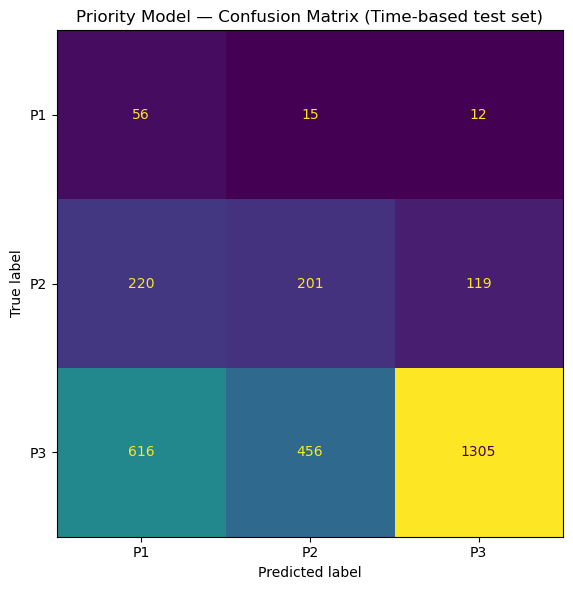

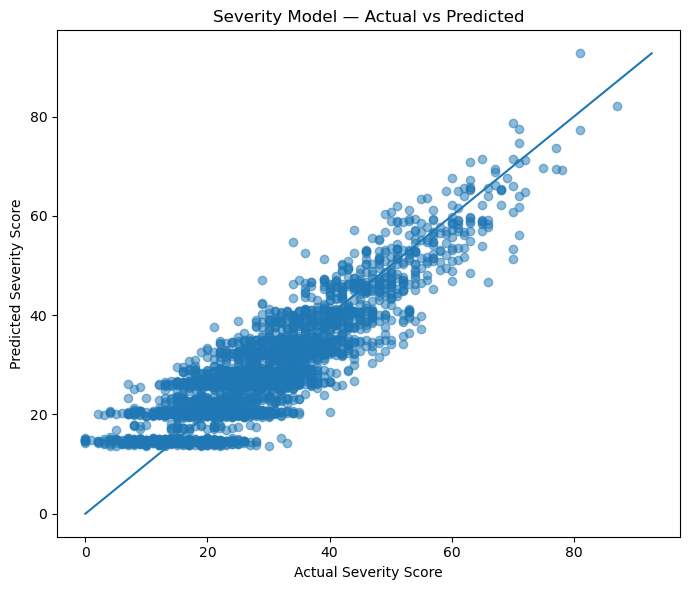

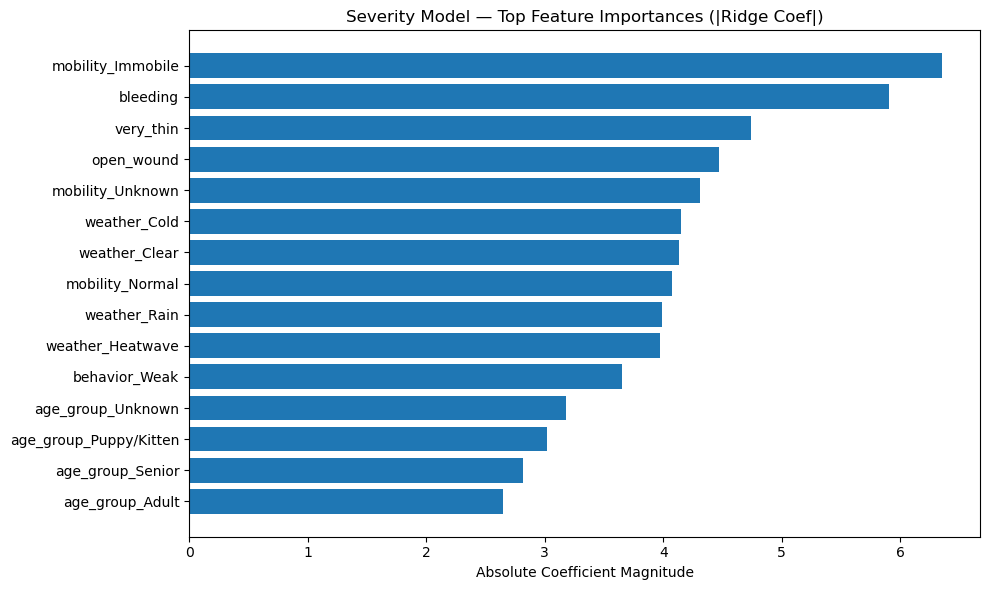

In [5]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1) Load data + models
# -----------------------------
df = pd.read_csv("incidents_tirana_v2.csv")
df["reported_at"] = pd.to_datetime(df["reported_at"], errors="coerce")
df = df.sort_values("reported_at").reset_index(drop=True)

priority_model = joblib.load("priority_model_tirana_v2.joblib")
severity_model = joblib.load("severity_model_tirana_v2.joblib")

# -----------------------------
# 2) Recreate the SAME features + time split
# -----------------------------
df["report_hour"] = df["reported_at"].dt.hour.fillna(0).astype(int)
df["report_dayofweek"] = df["reported_at"].dt.dayofweek.fillna(0).astype(int)
df["report_month"] = df["reported_at"].dt.month.fillna(1).astype(int)

feature_cols = [
    "neighborhood", "animal_type", "age_group",
    "behavior", "mobility", "traffic_risk",
    "weather", "report_channel", "visible_injury",
    "animal_count",
    "near_traffic", "near_school", "very_thin", "bleeding", "open_wound",
    "pregnant_or_nursing", "has_collar", "reporter_confidence",
    "report_hour", "report_dayofweek", "report_month"
]

X = df[feature_cols].copy()
y_priority = df["priority"].copy()
y_severity = df["severity_score"].copy()

split_idx = int(len(df) * 0.80)
X_test = X.iloc[split_idx:]
y_priority_test = y_priority.iloc[split_idx:]
y_severity_test = y_severity.iloc[split_idx:]

# Predictions
pred_priority = priority_model.predict(X_test)
pred_severity = severity_model.predict(X_test)
pred_severity = np.clip(pred_severity, 0, 100)

# -----------------------------
# PLOT 1) Priority Confusion Matrix
# -----------------------------
labels = ["P1", "P2", "P3"]
cm = confusion_matrix(y_priority_test, pred_priority, labels=labels)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, values_format="d", colorbar=False)
ax.set_title("Priority Model — Confusion Matrix (Time-based test set)")
plt.tight_layout()
plt.show()

# -----------------------------
# PLOT 2) Severity: Actual vs Predicted
# -----------------------------
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)

ax.scatter(y_severity_test, pred_severity, alpha=0.5)
min_v = min(y_severity_test.min(), pred_severity.min())
max_v = max(y_severity_test.max(), pred_severity.max())
ax.plot([min_v, max_v], [min_v, max_v])  # y=x reference line

ax.set_title("Severity Model — Actual vs Predicted")
ax.set_xlabel("Actual Severity Score")
ax.set_ylabel("Predicted Severity Score")
plt.tight_layout()
plt.show()

# -----------------------------
# PLOT 3) Severity Feature Importance (Top 15 by |coef|)
# (Works because your severity model is Ridge, linear coefficients)
# -----------------------------
prep = severity_model.named_steps["prep"]
ridge = severity_model.named_steps["model"]

# ColumnTransformer parts:
# numeric -> StandardScaler (names preserved)
# cat -> OneHotEncoder (expanded)
num_features = prep.transformers_[0][2]
ohe = prep.transformers_[1][1]
cat_features = prep.transformers_[1][2]

ohe_feature_names = list(ohe.get_feature_names_out(cat_features))
all_feature_names = list(num_features) + ohe_feature_names

coefs = ridge.coef_
abs_coefs = np.abs(coefs)

top_k = 15
top_idx = np.argsort(abs_coefs)[-top_k:][::-1]

top_names = [all_feature_names[i] for i in top_idx]
top_vals = abs_coefs[top_idx]

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.barh(top_names[::-1], top_vals[::-1])
ax.set_title("Severity Model — Top Feature Importances (|Ridge Coef|)")
ax.set_xlabel("Absolute Coefficient Magnitude")
plt.tight_layout()
plt.show()


In [7]:
pip install fastapi uvicorn pydantic joblib


  Using cached fastapi-0.128.0-py3-none-any.whl.metadata (30 kB)
  Using cached uvicorn-0.40.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached starlette-0.50.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached annotated_doc-0.0.4-py3-none-any.whl.metadata (6.6 kB)
Using cached fastapi-0.128.0-py3-none-any.whl (103 kB)
Using cached starlette-0.50.0-py3-none-any.whl (74 kB)
Using cached uvicorn-0.40.0-py3-none-any.whl (68 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.9 MB/s  0:00:01 eta 0:00:01
Using cached annotated_doc-0.0.4-py3-none-any.whl (5.3 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.232m 0/10 [typing-extensions]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [fastapi]9/10 [fastapi]]core]
Note: you may need to restart the kernel to use updated packages.


In [9]:

pip install --upgrade typing_extensions


Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install --upgrade fastapi pydantic


Note: you may need to restart the kernel to use updated packages.


In [1]:
import fastapi
import pydantic
import typing_extensions

print("FastAPI:", fastapi.__version__)
print("Pydantic:", pydantic.__version__)


FastAPI: 0.128.0
Pydantic: 2.12.5


In [2]:
import fastapi
print("FastAPI OK")


FastAPI OK


In [ ]:
!uvicorn app:app --reload --port 8001


INFO:     Will watch for changes in these directories: ['/Users/klodianahalilaj']
INFO:     Uvicorn running on http://127.0.0.1:8001 (Press CTRL+C to quit)
INFO:     Started reloader process [39856] using StatReload
INFO:     Started server process [39858]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     127.0.0.1:49607 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:49607 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [39858]
INFO:     Started server process [40209]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     127.0.0.1:49786 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:49786 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:49787 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:49809 - "POST /predict HTTP/1.1" 200 OK
INFO:     127.0.0.1:498